<a href="https://colab.research.google.com/github/zaku2590/classGCI/blob/main/comp2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install optuna

In [ ]:
# モジュールのインポート
import optuna
import numpy as np  # 数値計算や配列操作を行うためのライブラリ
import pandas as pd  # 表形式のデータを扱うためのライブラリ
import matplotlib.pyplot as plt  # データ可視化のための基本的なグラフ描画ライブラリ
import seaborn as sns  # 高機能な統計グラフを描画するライブラリ
from sklearn.preprocessing import LabelEncoder  # カテゴリ変数を数値に変換するエンコーダ
from sklearn.ensemble import RandomForestClassifier  # ランダムフォレストによる分類器
from lightgbm import LGBMClassifier
from sklearn.model_selection import StratifiedKFold ,cross_val_score # 層化K分割交差検証を行うクラス
from sklearn.metrics import roc_auc_score  # ROC AUCスコアを計算する評価指標
from sklearn.impute import KNNImputer
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

In [ ]:
PATH = '/content/'

train = pd.read_csv(PATH + 'train.csv')
test = pd.read_csv(PATH + 'test.csv')


In [ ]:
# 使わない列の削除
train = train.drop(columns=["Id", "School"])
test = test.drop(columns=["Id","School"])

# 平均で補完する対象の列
cols_to_fill = ['Age', 'Sprint_40yd', 'Vertical_Jump', 'Bench_Press_Reps',
                'Broad_Jump', 'Agility_3cone', 'Shuttle']

# # positionTypeで平均を埋める
# for col in cols_to_fill:
#     # train[col + "_was_missing"] = train[col].isnull().astype(int)
#     # test[col + "_was_missing"] = test[col].isnull().astype(int)

#     group_mean = train.groupby("Position_Type")[col].mean()
#     train[col] = train[col].fillna(train["Position_Type"].map(group_mean))
#     test[col] = test[col].fillna(test["Position_Type"].map(group_mean))

# # 補完器の定義（LightGBM等も指定できるが、デフォルトは線形回帰）
# iter_imputer = IterativeImputer(random_state=42)

# # 補完
# train[cols_to_fill] = iter_imputer.fit_transform(train[cols_to_fill])
# test[cols_to_fill] = iter_imputer.transform(test[cols_to_fill])

# # 補完器の定義（近傍5つで補完）
# knn_imputer = KNNImputer(n_neighbors=5)

# # 補完対象の列だけ抽出して補完
# train[cols_to_fill] = knn_imputer.fit_transform(train[cols_to_fill])
# test[cols_to_fill] = knn_imputer.transform(test[cols_to_fill])


# カテゴリデータをラベルエンコーディング
target_cols = ["Player_Type", "Position_Type", "Position"]

for col in target_cols:
    # trainデータで平均Draft率を計算
    target_mean = train.groupby(col)["Drafted"].mean()

    # 新しいエンコード列名（例：Player_Type_TE）
    new_col = col + "_TE"

    # train, test にmap（目的変数との平均を特徴にする）
    train[new_col] = train[col].map(target_mean)
    test[new_col] = test[col].map(target_mean)

    # 元のカテゴリ列を削除
    train = train.drop(columns=[col])
    test = test.drop(columns=[col])

In [ ]:
for df in [train, test]:
    df['BMI'] = df['Weight'] / (df['Height'] ** 2)

train["Power_Index"] = train["Vertical_Jump"] * train["Weight"]
test["Power_Index"] = test["Vertical_Jump"] * test["Weight"]

train["Speed_to_Jump"] = train["Sprint_40yd"] / train["Vertical_Jump"]
test["Speed_to_Jump"] = test["Sprint_40yd"] / test["Vertical_Jump"]

train["Jump_per_kg"] = train["Vertical_Jump"] / train["Weight"]
test["Jump_per_kg"] = test["Vertical_Jump"] / test["Weight"]

train["Strength_per_kg"] = train["Bench_Press_Reps"] / train["Weight"]
test["Strength_per_kg"] = test["Bench_Press_Reps"] / test["Weight"]

# Position_Type_TE,Player_Type_TEの二つを消したmaxから
train = train.drop(columns=["Vertical_Jump", "Shuttle"])
test = test.drop(columns=["Vertical_Jump", "Shuttle"])

train.head()

,Year,Age,Height,Weight,Sprint_40yd,Bench_Press_Reps,Broad_Jump,Agility_3cone,Drafted,Position_TE,BMI,Power_Index,Speed_to_Jump,Jump_per_kg,Strength_per_kg
0,2011,21.0,1.9050,140.160042,5.39,29.0,251.46,7.91,1.0,0.642384,38.621956,8366.152925,0.090300,0.425870,0.206906
1,2011,24.0,1.8288,87.089735,4.31,16.0,332.74,NaN,1.0,0.594937,26.039614,8848.317080,0.042421,1.166613,0.183719
2,2018,21.0,1.8542,92.986436,4.51,10.0,309.88,6.95,1.0,0.594937,27.046212,8502.679694,0.049322,0.983369,0.107543
3,2010,21.0,1.9304,148.778297,5.09,39.0,254.00,8.12,1.0,0.715000,39.925004,11336.906262,0.066798,0.512171,0.262135
4,2016,21.0,1.8796,92.079251,4.64,NaN,281.94,7.13,1.0,0.594937,26.063390,7250.320232,0.058928,0.855133,NaN


In [ ]:
# 特徴量と目的変数に分ける
X = train.drop(columns=["Drafted"])
y = train["Drafted"]

models = {
    "RandomForest": RandomForestClassifier(
        n_estimators=378,
        max_depth=7,
        min_samples_split=4,
        min_samples_leaf=5,
        max_features=None,
        random_state=2025,
        n_jobs=-1
    ),
    "LightGBM": LGBMClassifier(
        learning_rate=0.010488294829397215,
        num_leaves=96,
        max_depth=3,
        min_child_samples=74,
        subsample=0.6219322010855215,
        colsample_bytree=0.6022862354233319,
        reg_alpha=0.8351184813440499,
        reg_lambda=0.6559328766031582,
        n_estimators=1000,
        random_state=2025,
        verbosity=-1
    )
}

# クロスバリデーション設定
skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

# モデルごとのスコア・予測格納用辞書
model_auc_dict = {}
model_test_pred_dict = {}

for name, model in models.items():
    print(f"\n=== Model: {name} ===")
    auc_scores = []
    test_pred_proba_list = []

    for fold, (train_idx, valid_idx) in enumerate(skf.split(X, y)):
        print(f" Fold {fold + 1}")

        X_train, X_valid = X.iloc[train_idx], X.iloc[valid_idx]
        y_train, y_valid = y.iloc[train_idx], y.iloc[valid_idx]

        model.fit(X_train, y_train)
        y_valid_pred_proba = model.predict_proba(X_valid)[:, 1]

        auc = roc_auc_score(y_valid, y_valid_pred_proba)
        auc_scores.append(auc)
        print(f"  AUC: {round(auc, 4)}")

        test_pred_proba = model.predict_proba(test)[:, 1]
        test_pred_proba_list.append(test_pred_proba)

    mean_auc = np.mean(auc_scores)
    print(f"→ Average AUC for {name}: {round(mean_auc, 4)}")

    model_auc_dict[name] = mean_auc
    model_test_pred_dict[name] = np.mean(test_pred_proba_list, axis=0)

# AUC比較結果を表示
print("\n=== Model Comparison ===")
for name, auc in model_auc_dict.items():
    print(f"{name}: AUC = {round(auc, 4)}")


=== Model: RandomForest ===
 Fold 1
  AUC: 0.799
 Fold 2
  AUC: 0.8507
 Fold 3
  AUC: 0.8537
 Fold 4
  AUC: 0.7869
 Fold 5
  AUC: 0.8394
→ Average AUC for RandomForest: 0.8259

=== Model: LightGBM ===
 Fold 1
  AUC: 0.7998
 Fold 2
  AUC: 0.8521
 Fold 3
  AUC: 0.8516
 Fold 4
  AUC: 0.7917
 Fold 5
  AUC: 0.8502
→ Average AUC for LightGBM: 0.8291

=== Model Comparison ===
RandomForest: AUC = 0.8259
LightGBM: AUC = 0.8291


             Feature  Importance
4        Sprint_40yd         788
1                Age         758
7      Agility_3cone         488
10       Power_Index         386
13   Strength_per_kg         352
0               Year         334
9                BMI         269
8        Position_TE         269
12       Jump_per_kg         260
3             Weight         247
6         Broad_Jump         222
5   Bench_Press_Reps         210
11     Speed_to_Jump         202
2             Height         160


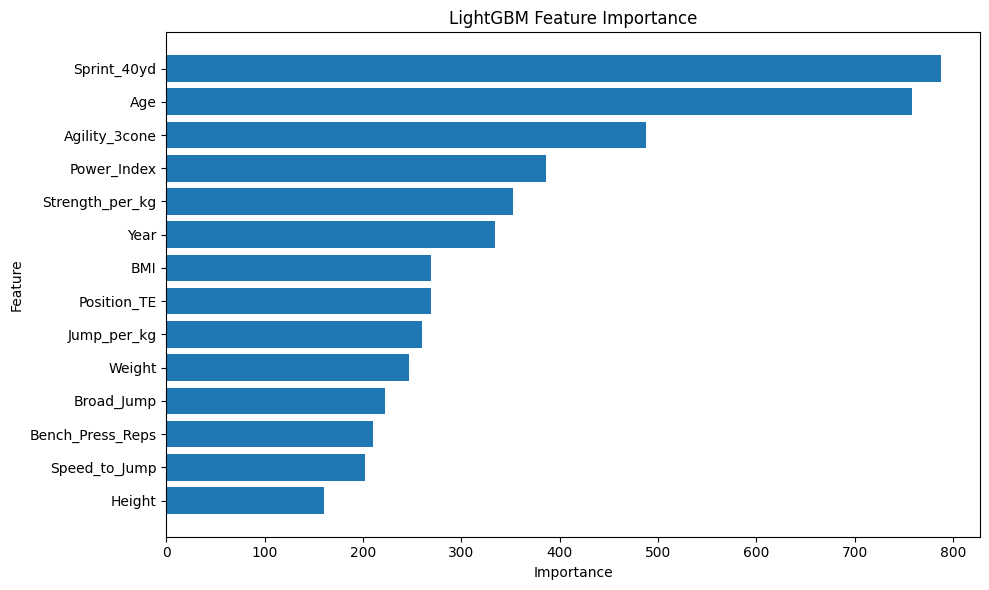

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# 学習（クロスバリデーションではなく全体で例示）
model = LGBMClassifier(
    learning_rate=0.010488294829397215,
    num_leaves=96,
    max_depth=3,
    min_child_samples=74,
    subsample=0.6219322010855215,
    colsample_bytree=0.6022862354233319,
    reg_alpha=0.8351184813440499,
    reg_lambda=0.6559328766031582,
    n_estimators=1000,
    random_state=2025,
    verbosity=-1
)
model.fit(X, y)

# 特徴量の重要度を取得
importances = model.feature_importances_
features = X.columns
importance_df = pd.DataFrame({
    'Feature': features,
    'Importance': importances
}).sort_values(by='Importance', ascending=False)

# 表示
print(importance_df)

# 可視化
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel("Importance")
plt.ylabel("Feature")
plt.title("LightGBM Feature Importance")
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()


In [ ]:
submission_template = pd.read_csv(PATH + 'sample_submission.csv')

for name, test_pred in model_test_pred_dict.items():
    submission = submission_template.copy()
    submission["Drafted"] = test_pred
    submission.to_csv(PATH + f"{name.lower()}_submission.csv", index=False)